# Saturation Spectroscopy on Rb

In [30]:
import pandas as pd
import scipy.optimize as opt 
from routines import plot_data, four_gauss, plot_interval,gauss
from uncertainties import ufloat
from uncertainties import unumpy
import scipy.fftpack
import scipy.signal as signal
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.patches as patches
from pandas.tools.plotting import table

%pylab inline
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

Populating the interactive namespace from numpy and matplotlib


/home/sebastian/miniconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['table', 'cov']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [31]:
# Dictionary that will be used to hold all data that will be processed in the bokeh script
bokeh_data = {}

## Doppler Broadened Spectrum

### Preprocessing

#### Import Raw Data

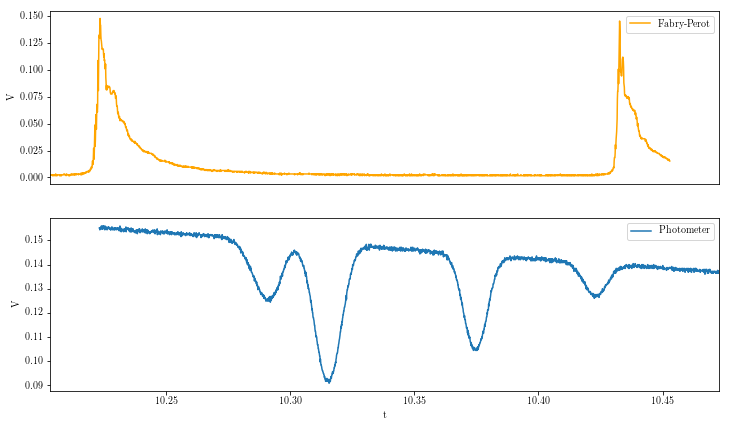

In [32]:
# import data

folder = "02-13/broadened/falling"
falling = True

path_doppler = "clean/" + folder + "/doppler.csv"
path_fp = "clean/" + folder + "/fp.csv"

doppler = pd.DataFrame.from_csv(path_doppler,index_col=None)
fp = pd.DataFrame.from_csv(path_fp,index_col= None)

#offsets
fp.t = fp.t
fp.V = fp.V/5

# show data 
figsize(12,7)
plot_data(doppler,fp);

bokeh_doppler = pd.DataFrame(doppler)

#### Remove Background

Remove the background signal that is a result of the rectangular modulation in laser current.

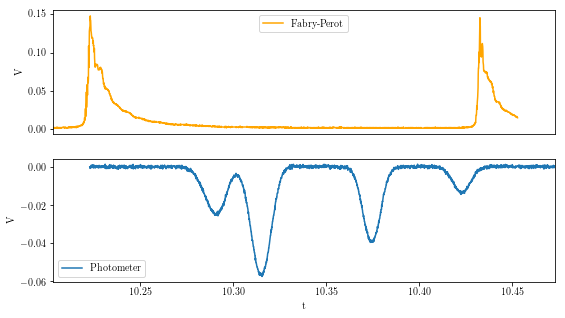

In [33]:
def remove_background(data, fit_data, func, initial_guess = None):
    
    par,cov = opt.curve_fit(func,fit_data.t,fit_data.V,initial_guess)
    data_clean = data.copy()
    data_clean.V = data.V-func(data.t,*par)
    
    return data_clean , par

def lin(x,a,b): # linear function for fit
    return a*x+b

# For background, only fit parts without peaks
fit_subset = doppler[:200].append(doppler[-20:])
photo_nb , par = remove_background(doppler,fit_subset,lin)
photo_nb.V =  photo_nb.V
figsize(9,5)
plot_data(photo_nb,fp);


#savefig('broadened.pdf')

###  Analyze Fabry-Perot

The Fabry-Perot spectrum is used to calibrate the time-axis on the oscilloscope. The FP spectrometers peaks are always separated by 10 Ghz, this is called the free spectral range or FSR.

In [34]:
#left maximum
fp_lpeak = np.array(fp[0:math.floor(len(fp.t)/2)].sort_values('V').t)[-1]

#right maximum 
fp_rpeak = np.array(fp[math.floor(len(fp.t)/2):].sort_values('V').t)[-1]

fsr = fp_rpeak - fp_lpeak

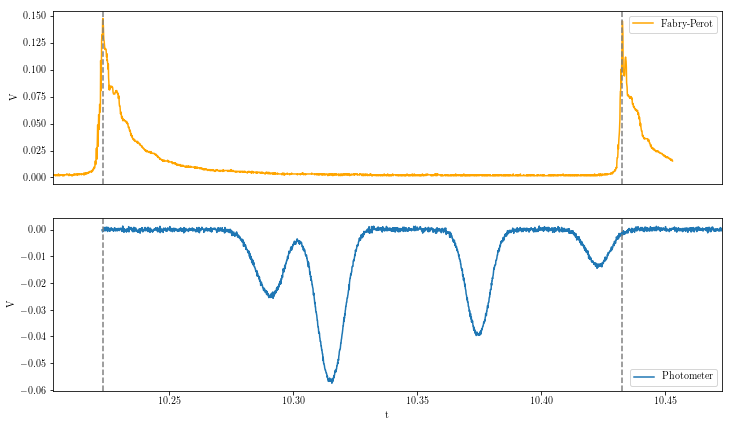

In [35]:
figsize(12,7)
plot_data(photo_nb,fp)

def plot_fplines(subplots =2):
    for i in range(min(2,subplots)):
        subplot(subplots,1,i+1)
        axvline(fp_lpeak, ls = '--',color = 'grey')
        axvline(fp_rpeak, ls = '--', color = 'grey')    

plot_fplines()

### Analyze Photometer spectrum

In [36]:
# Fit the data

# Load file with save values for mu if it exists. If not use mu_guess and save later if success. 
# mu corresponds to the peak positions in the doppler broadened spectrum. To achieve convergence of the 
# least square fitting algorithm, a good initial guess should be provided.

try:
    mu_file = open("./clean/" + folder + "/mu_guess",'r')
    mu_guess = []
    for line in mu_file:
        mu_guess += [float(line.strip())]
except FileNotFoundError as e:
    mu_guess=[10.03,10.06,10.12,10.14]
    
guess = [-.05,-.05,-.05,-.05,*mu_guess,.005,.005,.005,.005]
par, cov = opt.curve_fit(four_gauss, photo_nb.t, photo_nb.V, guess)

### Peaks and uncertainties

#peaks[{x:0/y:1}][index]
peaks = np.array([par[4:8],par[0:4]])

#their errors (1 sigma)
peaks_err = np.array([[np.sqrt(cov[i,i]) for i in range(4,8)],[np.sqrt(cov[i,i]) for i in range(0,4)]])

In [37]:
# Data Frame with peak positions and heights

index = ['87_F2','85_F3','85_F2','87_F1']
if not falling:
    index = index[::-1]

spectrum = pd.DataFrame({'x' : pd.Series(par[4:8],index),
    'y':  pd.Series(par[0:4],index),
    'sig_x': pd.Series(peaks_err[0],index),
    'sig_y': pd.Series(peaks_err[1],index),
    'width': pd.Series(par[8:12],index),
    'sig_width': pd.Series([np.sqrt(cov[i,i]) for i in range(8,12)],index)})

spectrum

,sig_width,sig_x,sig_y,width,x,y
87_F2,0.000018,0.000018,0.000068,0.005608,10.290474,-0.024994
85_F3,0.000008,0.000007,0.000071,0.005175,10.315141,-0.057517
85_F2,0.000010,0.000010,0.000074,0.004653,10.374536,-0.039835
87_F1,0.000030,0.000030,0.000074,0.004675,10.422916,-0.013536


### Plotting

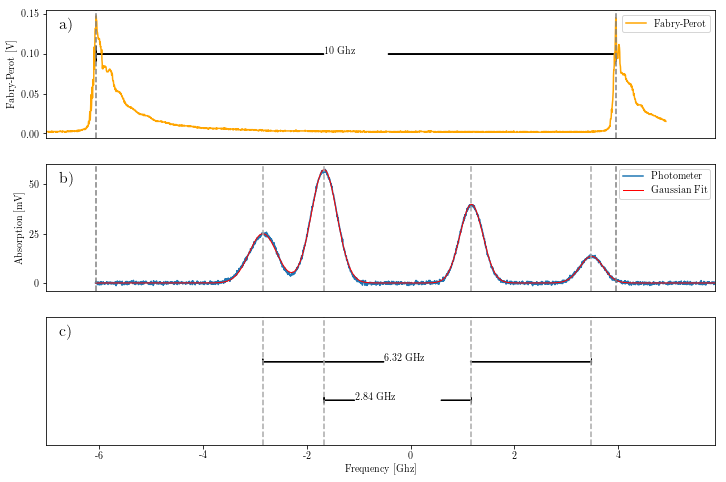

In [38]:
figsize(12,8)
if np.mean(photo_nb.V) < 0:
    photo_nb.V = -photo_nb.V
xl = plot_data(photo_nb,fp,subplots=3)

ylabel('Fabry-Perot [V]')
subplot(3,1,2)
plot(photo_nb.t,-four_gauss(photo_nb.t,*par),label = 'Gaussian Fit',color = 'red',linewidth = 1)
xticks([])
xlabel('')
ylabel('Absorption [mV]')
yticks(np.arange(0,0.051,0.025), np.arange(0,51,25))


plot_fplines(3)

subplot(3,1,3)

xlabel('Frequency [Ghz]')
#xticks(np.arange(-5,5,1))
xlim(xl)
yticks([])
for i in range(2,4):
    for pos in spectrum.x:
        subplot(3,1,i)
        axvline(pos,color= 'darkgrey',ls = '--')
        
subplot(3,1,3)
scale = 10e3/fsr #MHz
xticks(np.arange(-6000,6000,2000)/scale +10.35,np.arange(-6,6,2))

##uncertainties in intervals

interval_32 = ufloat(abs(spectrum.x['85_F2']-spectrum.x['85_F3']),np.sqrt(spectrum.sig_x['85_F2']**2+spectrum.sig_x['85_F3']**2))
interval_21 = ufloat(abs(spectrum.x['87_F1']-spectrum.x['87_F2']),np.sqrt(spectrum.sig_x['87_F1']**2+spectrum.sig_x['87_F2']**2))


plot_interval(spectrum.x['85_F3'],spectrum.x['85_F2'],0.35, 
              str(round(interval_32.n*scale/1000,2)) + " GHz" ,.0174)
plot_interval(spectrum.x['87_F2'],spectrum.x['87_F1'],0.65,
              str(round(interval_21.n*scale/1000,2)) + " GHz",.0174)

subplot(3,1,1)
plot_interval(fp_lpeak,fp_rpeak,.1, " 10 Ghz",.013,hw = .02)



ax = subplot(3,1,1)
text(0.02, 0.95, 'a)', transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top')
ax = subplot(3,1,2)
text(0.02, 0.95, 'b)', transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top')
legend(loc=1)
ax = subplot(3,1,3)
text(0.02, 0.95, 'c)', transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top');

# savefig("./clean/" + folder + "/spectrum.pdf",bbox_inches='tight')


### Save mu

In [39]:
with open("./clean/" + folder + "/mu_guess",'w') as mu_file:
    for mu in mu_guess:
        mu_file.write(str(mu)+'\n')

## Saturated Spectrum

### Preprocessing

#### Import Data

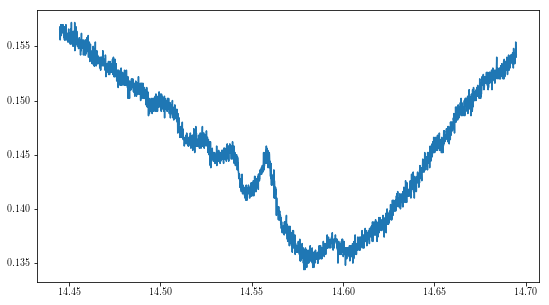

In [40]:
folder = "02-13/saturated/falling"

path_saturated = "clean/" + folder + "/saturated.csv"
path_doppler = "clean/" + folder + "/doppler.csv"

saturated = pd.DataFrame.from_csv(path_saturated,index_col=None)
doppler = pd.DataFrame.from_csv(path_doppler,index_col= None)

# show data 
figsize(9,5)
plot(saturated.t,saturated.V);

In [41]:
# Functions used for fitting the spectrum

def lorentzian(x,N,x0,gamma):
    return N/((1+((x-x0)/gamma)**2))

def two_gauss_os(x,N1,N2,mu1,mu2,sig1,sig2,os):
    return gauss(x,N1,mu1,sig1) + gauss(x,N2,mu2,sig2) + os

def gauss_os(x,N1,mu1,sig1,os):
    return gauss(x,N1,mu1,sig1) + os

def lin(x,a,b):
    return a*(x)+b

#### Compare doppler broadened and saturated

We "zoomed in" on one peak - 87Rb(F = 2 -> ?) - and recorded the unsaturated and saturated spectrum

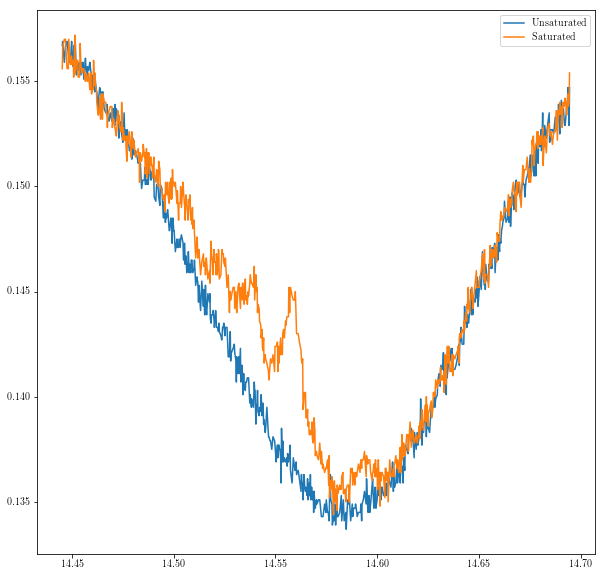

In [42]:
figsize(10,10) 
background = doppler.copy()

# These parameters have to be hand-adjusted for every Dataset for good agreement
#background.t += 0.016 # 02-13 rising
background.t -= 0.005 # 02-13 falling
#background.V += 0.0105 # 02-13 rising
background.V += 0.0111 # 02-13 falling

merged = pd.merge(background,saturated, how='inner',on=['t'])

plot(merged.t,merged.V_x, label = 'Unsaturated')
plot(merged.t,merged.V_y, label = 'Saturated')
legend();

#### Subract linear background from absorption spectrum

Again, we have to subract the linear background produced by the current modulation from both signals

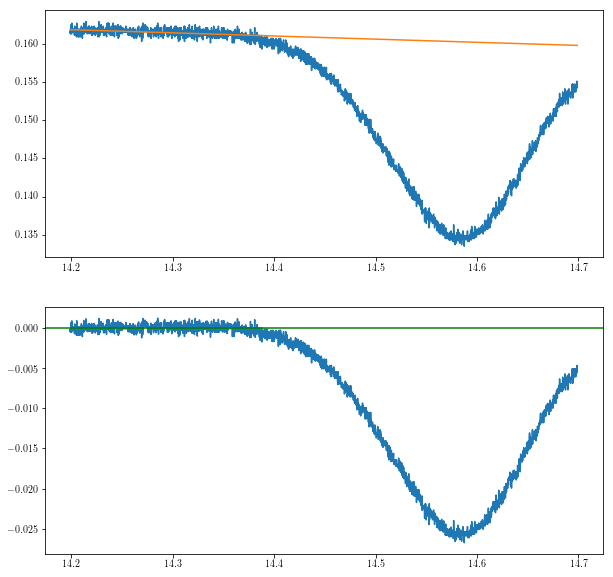

In [43]:
lin_fit_data = background[background.t < 14.38] # 02-13 falling
#lin_fit_data = background[background.t> 12.03] # 02-13 rising
par_back_lin, cov_back_lin = opt.curve_fit(lin,lin_fit_data.t,lin_fit_data.V)
subplot(2,1,1)
plot(background.t,background.V)
plot(background.t,lin(background.t,*par_back_lin))

background.V = background.V-lin(background.t,*par_back_lin)
subplot(2,1,2)
plot(background.t,background.V)
axhline(0,color ='green')

Because we cannot use the FP spectrometer to calibrate the time axis in this case, we fit the unsaturated peak 
and compare its width to the corresponding peak's in our previous measurement. As both widhts should be the same in frequency, we can easily determine the scaling factor. 

 The scaling factor between the doppler broadened measurement and the saturated  measurement is 3947+/-14


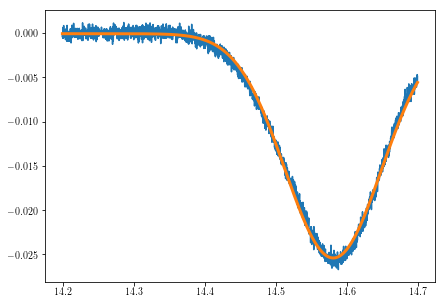

In [44]:
#Fit doppler broadened (unsaturated) peak (to determine scaling factor)

figsize(7,5)
#guess = [-0.04,-0.02,11.6,11.85,.1,.1,0.16] # 02-13 rising
guess = [-0.04,14.6,.1,0.16] # 02-13 falling

fit_func = gauss_os # 02-13 falling
#fit_func = two_gauss_os # 02-13 rising

#par_background, cov_background = opt.curve_fit(two_gauss_os,background.t,background.V,guess) # 02-13 rising
par_background, cov_background = opt.curve_fit(fit_func,background.t,background.V,guess) # 02-13 falling
plot(background.t,background.V)
plot(background.t,fit_func(background.t,*par_background),lw = 3)

scattersigma = np.sqrt(((background.V-fit_func(background.t,*par_background))**2).sum())/np.sqrt(len(background.V))

#sigma_background = ufloat(par_background[5],cov_background[5,5]) # 02-13 rising
sigma_background = ufloat(par_background[2],np.sqrt(cov_background[2,2])) # 02-13 falling

F2_width_doppler = ufloat(spectrum.width['87_F2'],spectrum.sig_width['87_F2'])

scale_sat = F2_width_doppler*scale/sigma_background
print(' The scaling factor between the doppler broadened measurement and the saturated ' +\
      ' measurement is {}'.format(scale_sat))

#### Signal processing

Because we are measuring with a very high resolution, the signal contains a lot of noise that we can filter out by employing a method call LOWESS (Locally Weighted Scatterplot Smoothing). The hyperparameters of this smoothening algorithm should be hand-tuned to achieve good results

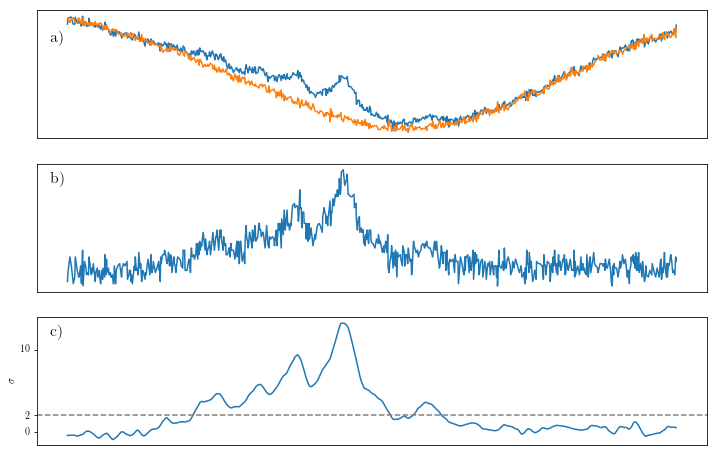

In [45]:
figsize(12,8)

sat_nb = pd.DataFrame([merged.t,(merged.V_y-merged.V_x)])
sat_nb = sat_nb.transpose()
sat_nb.columns = ['t','V']
sat_nb.head()


ax = subplot(3,1,1)
ax.set_xticks([])
ax.set_yticks([])
plot(merged.t,merged.V_y)
plot(merged.t,merged.V_x)


ax = subplot(3,1,2)
ax.set_xticks([])
ax.set_yticks([])
plot(sat_nb.t,sat_nb.V)


### ============ LOWESS smoothening, hand-tune here !!! ==================

#filtered = lowess(sat_nb.V,sat_nb.t,frac = 0.018, it=0) # 02-13 rising
filtered = lowess(sat_nb.V,sat_nb.t,frac = 0.028, it=0) # 02-13 falling

sat_filtered = pd.DataFrame([filtered[:,0],filtered[:,1]])
sat_filtered = sat_filtered.transpose()
sat_filtered.columns = ['t','V']

ax = subplot(3,1,3)
ax.set_xticks([])
plot(sat_filtered.t,sat_filtered.V/scattersigma)

#axhline(1,ls='--',color='grey',label='2$\sigma$') 
axhline(2,ls='--',color='grey',label='2$\sigma$')
ax.set_ylabel("$\sigma$")
ax.set_yticks([0,2,10])
#legend()

ax = subplot(3,1,1)
text(0.02, 0.85, 'a)', transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top')
ax = subplot(3,1,2)
text(0.02, 0.95, 'b)', transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top')
ax = subplot(3,1,3)
text(0.02, 0.95, 'c)', transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top');

# savefig("./clean/"+ folder + "/data_manip.pdf",bbox_inch='tight')


a) Saturated and Unsaturated spectrum

b) Saturated - Unsaturated spectrum 

c) Spectrum from b) smoothened with LOWESS and normalized to the standard deviation $\sigma$ of the noise.
   Dashed grey line gives the cutoff $2\sigma$ that we require to identify a peak as such

### Analysis

AttributeError: 'DataFrame' object has no attribute 'V'

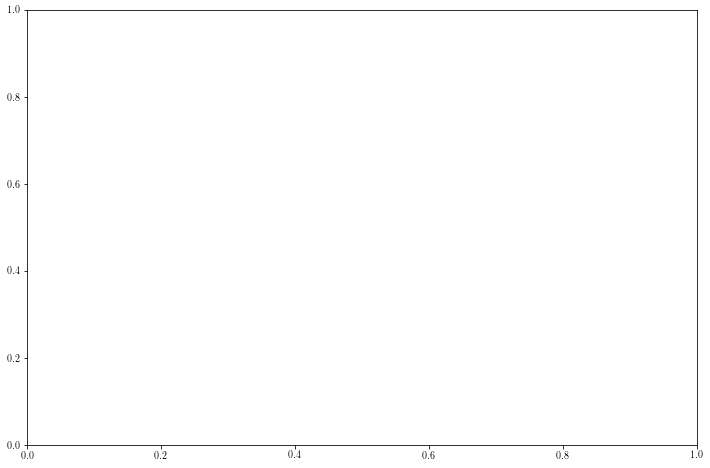

In [56]:


figsize(12,8)

# ============ Some fitting parameters that need to be hand tuned ============
    # width: approximate width of the peaks 
    # left-pos: approximate peak position - width / 2
    # parameters don't have to be exact, just in the ballpark of the actual peaks
    
width = [0.004,0.004,0.006,0.006,0.006,0.006]
#left_pos = [11.815,11.848,11.866,11.878,11.898,11.912] # 02-13 rising
left_pos = [14.484,14.504,14.521,14.536,14.5555,14.59] # 02-13 falling

# truncate data so only important peaks are shown
sat_filtered_trunc = sat_filtered[(sat_filtered.t > (left_pos[0] - 2*width[0])) & 
                                  (sat_filtered.t < (left_pos[-1] + 4*width[0]))]


fig,ax = subplots()
ax.plot(sat_filtered_trunc.t,sat_filtered_trunc.V,label = 'Filtered Signal')

axhline(scattersigma*2,ls='-',color='grey',alpha=.3)
par_peaks = []
par_peaks_xerr = []

labels = ['F=3','CO','CO','F=2','CO',"F=1?"]
if falling:
    labels = labels[::-1]
    
i = 0
 
# Fitting the data for each area and plotting the fitted functions,
# parameters are saved in par_peaks

peak_sig = []

for x,w in zip(left_pos,width):
    fit_data = sat_filtered_trunc[(sat_filtered_trunc.t > x) & (sat_filtered_trunc.t < (x+w))]
    #ax.plot(fit_data.t,fit_data.V)
    x0 = x+w/2
    N = max(fit_data.V)
    gamma = w  
    par, cov = opt.curve_fit(lorentzian,fit_data.t,fit_data.V,[N,x0,gamma])
    plt_label = "x0=" + str(par[1])  
    ax.plot(fit_data.t,lorentzian(fit_data.t,*par),label=plt_label)
    ax.annotate(labels[i],xy = (par[1]-0.005,par[0]+0.0001),textcoords='data')
    axvline(par[1],ls = "--", alpha = .3)
    par_peaks.append(par)
    peak_sig.append(np.sqrt(cov[1,1]))
    
    i+=1

#Data frame with parameters
ylim([-0.001,0.0083])


ylabel("$\sigma$")
xlabel("Frequency [MHz]")
spectrum_sat = pd.DataFrame(par_peaks)
spectrum_sat.columns = ['y','x','width']
spectrum_sat.index = labels
#axvline((spectrum_sat.x['F=2']-157.1/scale_sat).n,color ='green', ls='--', alpha = .3)

u_x = [ufloat(x,peak_sig[cnt]) for (x,cnt) in zip(spectrum_sat.x,range(len(spectrum_sat.x)))]
spectrum_sat['x'] = u_x   
spectrum_sat.x = (spectrum_sat.x)*scale_sat




yticks(np.arange(0,16,2)*scattersigma,np.arange(0,16,2))
xticks([x.n/scale_sat.n for x in spectrum_sat.x],[round(x.n-spectrum_sat.x["F=2"].n,2) for x in spectrum_sat.x])

# savefig("./clean/" + folder + "/hyperfine_spectrum.pdf",bbox_inches='tight')
# legend()
spectrum_sat



The peaks are fitted with lorentzians as indicated by the colored regions. The peak positions are given by the dashed vertical lines and labeled accordingly, where CO stands for cross-over peak (see paper for more information).
Again the y-axis (Intensity) is normalized to the standard deviation of the noise.

## Comparison to theory  

### Doppler Broadened

In [19]:
# Some natural constants 
kb = 1.38065e-23
c =  299792558
T = 295.15
M_85 = 1.409993e-25

In [20]:
def two_gauss(x,N1,N2,mu1,mu2,sig1,sig2):
    return gauss(x,N1,mu1,sig1)+ gauss(x,N2,mu2,sig2)

#### Import data from csv file

Theoretical values from 

*P. Siddons, C. S. Adams, C. Ge, and I. G. Hughes, Jour-
nal of Physics B: Atomic, Molecular and Optical Physics11
41, 155004 (2008)*

In [21]:
sff = pd.DataFrame.from_csv('parameters/sff.csv')
freq = pd.DataFrame.from_csv('parameters/freq.csv')


d_line_87 = 384.2304844e6
d_line_85 = 384.2304064e6


frequencies_85 = np.zeros([2,4])
for i in range(2):
    for j in range(i,i+3):
        frequencies_85[i,j] = d_line_85 + freq['Rb85-S'][2+i] + freq['Rb85-P'][1+j]
        
df_freq_85 = pd.DataFrame(frequencies_85,columns=['1','2','3','4'],index = ['2','3'])


frequencies_87 = np.zeros(8).reshape(2,4)
for i in range(2):
    for j in range(i,i+3):
        frequencies_87[i,j] = d_line_87 + freq['Rb87-S'][1+i]  + freq['Rb87-P'][j]
        
df_freq_87 = pd.DataFrame(frequencies_87,columns=['0','1','2','3'],index = ['1','2'])


### Rb85 expected spectrum

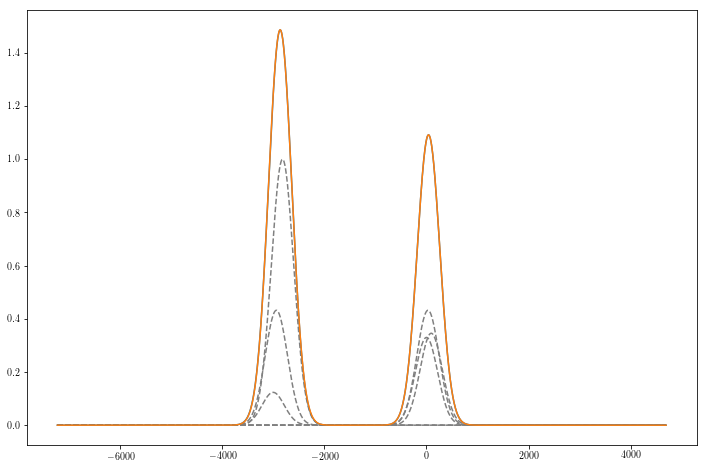

In [22]:
sigma_85 = np.array(np.sqrt(kb*T/(M_85*(c**2)))*df_freq_85).flatten()
mu_85 = np.array(df_freq_85 - df_freq_85['1'][0]).flatten()
N_85 = np.array(sff[2:4])[:,1:5].flatten()
np.array(df_freq_85).flatten()

# x= np.arange(-6000,3000,10)
x = photo_nb.t*scale - spectrum.x['85_F2']*scale
y_85= np.zeros(len(x))

y_gauss_85 = []
for i in range(8):
    if(sigma_85[i] != 0):
        y_85 += gauss(x,N_85[i],mu_85[i],sigma_85[i])
        plot(x,gauss(x,N_85[i],mu_85[i],sigma_85[i]),color = 'grey',ls = '--')
        y_gauss_85.append(gauss(x,N_85[i],mu_85[i],sigma_85[i]))
    else:
        y_gauss_85.append(np.zeros(len(x)))
        
par_85, cov = opt.curve_fit(two_gauss,x,y_85,[1,1,-3000,0,217,217])
plot(x,y_85)
plot(x,two_gauss(x,*par_85))

### Rb87 expected spectrum

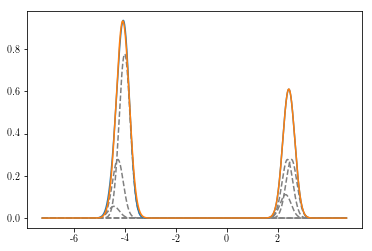

In [23]:
 M_87 = 1.44316077e-25

sigma_87 = np.array(np.sqrt(kb*T/(M_87*(c**2)))*df_freq_87).flatten()
mu_87 = np.array(df_freq_87 - df_freq_85['1'][0]).flatten() - 80
N_87 = np.array(sff[0:2])[:,0:4].flatten()

figsize(6,4)
# x = np.arange(-6000,3000,10)
x = photo_nb.t*scale - spectrum.x['85_F2']*scale
y_87= np.zeros(len(x))
y_gauss_87 = []

for i in range(8):
    if(sigma_87[i] != 0):
        y_87 += gauss(x,N_87[i],mu_87[i],sigma_87[i])
        plot(x,gauss(x,N_87[i],mu_87[i],sigma_87[i]),color = 'grey',ls = '--')
        y_gauss_87.append(gauss(x,N_87[i],mu_87[i],sigma_87[i]))
    else:
        y_gauss_87.append(np.zeros(len(x)))

plot(x,y_87)

xticks(np.arange(-6000,3000,2000),np.arange(-6,3,2))

par_87, cov = opt.curve_fit(two_gauss,x,y_87,[.7,1,-4000,2000,217,217])
plot(x,two_gauss(x,*par_87))
scale_85 = abs(spectrum.y['85_F3'])/par_85[0]
scale_87 = abs(spectrum.y['87_F1'])/par_87[1]

### Spectrum for both Rb isotopes - Theory compared to experiment

#### Quantitative comparison

In [24]:
#Gaps
gap_87 = abs((ufloat(spectrum.x['87_F2'],spectrum.sig_x['87_F2']) - ufloat(spectrum.x['87_F1'],
                                                                          spectrum.sig_x['87_F1']))*scale)
gap_85 = abs((ufloat(spectrum.x['85_F3'],spectrum.sig_x['85_F3']) - ufloat(spectrum.x['85_F2'],
                                                                          spectrum.sig_x['85_F2']))*scale)
expected_gap_87 = par_87[3] - par_87[2]
expected_gap_85 = par_85[3] - par_85[2]

#Ratio of amplitudes

amp_87 = abs((ufloat(spectrum.y['87_F2'],spectrum.sig_y['87_F2'])/ufloat(spectrum.y['87_F1'],
                                                                          spectrum.sig_x['87_F1'])))
amp_85 = abs((ufloat(spectrum.y['85_F3'],spectrum.sig_y['85_F3'])/ufloat(spectrum.y['85_F2'],
                                                                          spectrum.sig_x['85_F2'])))
expected_amp_87 = par_87[0]/par_87[1]
expected_amp_85 = par_85[0]/par_85[1]

results_doppler = pd.DataFrame([[expected_gap_87,gap_87],[expected_gap_85,gap_85],[expected_amp_87,amp_87],
                                [expected_amp_85,amp_85]])
results_doppler.columns = ['Theoretical', 'Measured']
results_doppler.index = ['Gap Rb87', 'Gap Rb85', 'Amp. ratio Rb87', 'Amp. ratio Rb85']

#### Plotting

,Theoretical,Measured
Gap Rb87,6511.541455,6324.8+/-1.6
Gap Rb85,2909.527534,2836.4+/-0.6
Amp. ratio Rb87,1.527590,1.846+/-0.006
Amp. ratio Rb85,1.361749,1.4439+/-0.0018


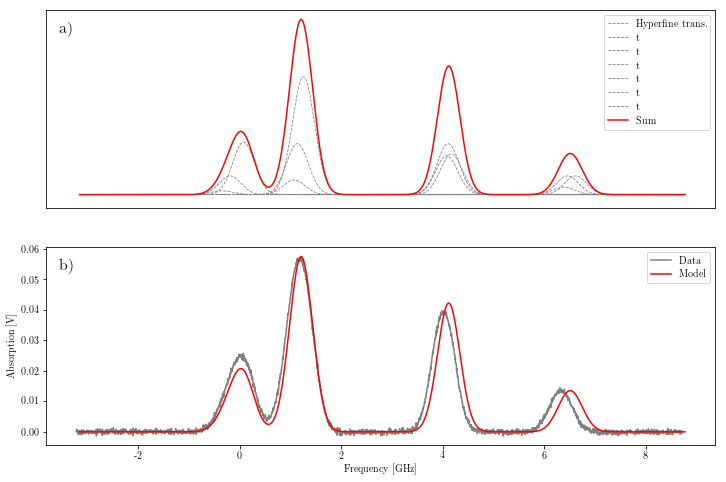

In [25]:
figsize(12,8)
ax = subplot(2,1,1)
text(0.02, 0.95, 'a)', transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top')

i = 0
theory_ds = pd.DataFrame()
theory_ds['t'] = x - par_87[3]

for j, y_g_85 in enumerate(y_gauss_85):
    if i is 0:
        plot(x-par_87[2],y_g_85 * scale_85,color = 'grey',ls = '--',lw = .8,label = 'Hyperfine trans.')
        i = 1
    else:
        plot(x-par_87[2],y_g_85 * scale_85,color = 'grey',ls = '--',lw = .8,label = '_nolegend_')
    theory_ds['hyperfine_{}'.format(j)] = y_g_85 * scale_85
    
    
for j, y_g_87 in enumerate(y_gauss_87):
    plot(x-par_87[2],y_g_87 * scale_87,color = 'grey',ls = '--',lw = .8)
    theory_ds['hyperfine_{}'.format(j+len(y_gauss_85))] = y_g_87 * scale_87
    
plot((photo_nb.t-spectrum.x['87_F2'])*scale,photo_nb.V, color = 'grey',alpha = 0, label = '_nolegend_')    
plot(x-par_87[2],y_85 * scale_85 + y_87 * scale_87,color = 'red', label = 'Sum')

xticks(np.arange(-2000,10000,2000),np.arange(-2,10,2))
xticks([])
yticks([])
legend()

ax = subplot(2,1,2)
text(0.02, 0.95, 'b)', transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top')

plot((photo_nb.t-spectrum.x['87_F2'])*scale,photo_nb.V, color = 'grey',label = 'Data')
plot(x-par_87[2],y_85 * scale_85 + y_87 * scale_87,color = 'red', label = 'Model')

ylabel('Absorption [V]')
xlabel('Frequency [GHz]')
xticks(np.arange(-2000,10000,2000),np.arange(-2,10,2))
legend()
# savefig("./clean/" + folder + "/theory_doppler.pdf",bbox_inches='tight')
results_doppler

a) Dashed grey lines: Hyperfine peaks that make up the doppler broadened peaks (red solid line) - Theoretical values

b) Comparison of the theoretical values (model) to the measured ones (data).


In [ ]:
photo_nb.t = (photo_nb.t-spectrum.x['87_F1'])*scale/1000
fp.t = (fp.t-spectrum.x['87_F1'])*scale/1000
theory_ds.t /= 1000
photo_nb['photo_nb'] = photo_nb.V
photo_nb = photo_nb.drop('V', axis = 1)
master_df = pd.merge_asof(photo_nb, theory_ds, on = ['t'])
bokeh_doppler.t = (bokeh_doppler.t -spectrum.x['87_F1'])*scale/1000
bokeh_doppler['photo_raw'] = bokeh_doppler.V
bokeh_doppler = bokeh_doppler.drop('V', axis = 1)

master_df = pd.merge_asof(master_df, bokeh_doppler, on = ['t'] )

bokeh_data['Broadened'] = master_df
bokeh_data['FP'] = fp


### Saturated 

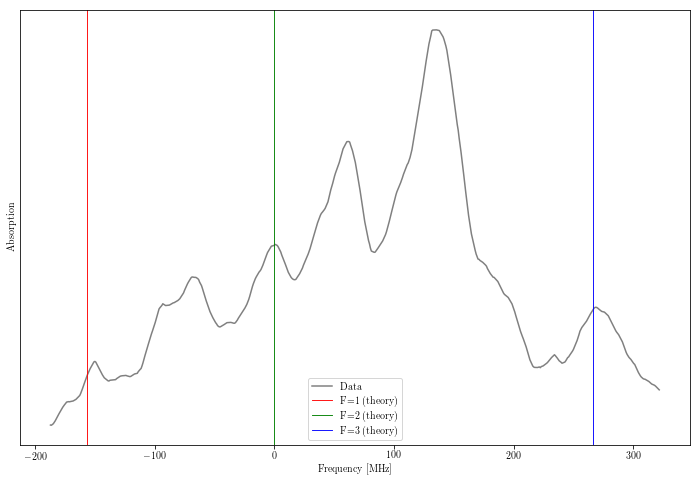

In [345]:
plot((sat_filtered_trunc.t- spectrum_sat.x['F=2'].n/scale_sat.n)*scale_sat.n,sat_filtered_trunc.V,
     label = 'Data',color = 'grey')

labels = ['F=1 (theory)','F=2 (theory)', 'F=3 (theory)','']
colors = ['red','green','blue']

i = 0
for line_x in (freq['Rb87-P']-freq['Rb87-P'][2])[1:4]:
    axvline(line_x,lw = .9,color = colors[i], label = labels[i])
    i+= 1
yticks([])#Quantitative comparison
ylabel("Absorption")
xlabel('Frequency [MHz]')
legend()
# savefig("./clean/" + folder + "/theory_sat.pdf",bbox_inches='tight')
None

Figure: Measured absorption spectrum for saturated spectroscopy compared to model predictions. The colored vertical lines give the peak positions predicted by our theoretical model. 
The y-axis is the absorption strength in arbitrary units.

In [ ]:
merged.columns = ['t','sat_background','sat_raw']
sat_nb.columns = ['t','sat_nb']
sat_filtered.columns = ['t', 'sat_filtered']

bokeh_data['Saturated'] = pd.merge_asof(merged,sat_nb, on =['t'])
bokeh_data['Saturated'] = pd.merge_asof(bokeh_data['Saturated'],sat_filtered, on = ['t'])
bokeh_data['Saturated'].t -= par_background[1]
bokeh_data['Saturated'].t *= scale_sat.n